# 多元高斯

多维不确定性建模

In [2]:
%matplotlib inline
#format the book
import lean.book_format as book_format
book_format.set_style()

## 一、介绍

上一章中的技术非常强大，但它们只适用于一个变量或维度。它们无法表示多维数据，例如狗在田野中的位置和速度。位置和速度是相互关联的，正如我们在g-h章节中学到的那样，我们永远不应该丢弃信息。在本章中，我们将学习如何以概率方式描述这种关系。通过这一关键见解，我们将实现明显更好的滤波器性能。

## 二、多元正态分布

我们一直在使用高斯作为标量随机变量，表示为 $\mathcal{N}(\mu, \sigma^2)$。一个更正式的术语是单变量正态，其中单变量表示“一个变量”。高斯的概率分布称为单变量正态分布。

多元正态分布可能是什么？多元意味着多变量。我们的目标是能够表示具有多个维度的正态分布。我不一定是指空间维度——如果我们以（x，y，z）跟踪飞机的位置，速度和加速度，就会给我们一个九维问题。考虑一个二维案例。它可能是机器人的x和y坐标，可能是狗在x轴上的位置和速度，或者奶牛场的产奶量和饲料速率。这并不重要。我们可以看到 𝑁 尺寸，我们需要 𝑁 表示，我们将在列矩阵（向量）中排列，如下所示：

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

假设我们相信 $x = 2$ 和 $y = 17$ 。我们会有

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

下一步是表示我们的方差。乍一看，我们可能会认为我们还需要 N 个维度的 N 个方差。我们可能想说 x 的方差是 10，y 的方差是 4，就像这样。

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

这是不完整的，因为它没有考虑更一般的情况。在高斯一章中，我们计算了学生身高的变化。这是衡量高度如何相对于彼此变化的度量。如果所有学生的身高相同，则方差为 0，如果他们的身高相差很大，则方差会很大。

身高和体重之间也有关系。一般来说，较高的人比矮个子的人体重更重。身高和体重是相关的。我们想要一种方法，不仅要表达我们认为身高和体重的差异，还要表达它们的相关性程度。换句话说，我们想知道体重与身高相比如何变化。我们称之为协方差。

在我们理解多元正态分布之前，我们需要了解相关性和协方差背后的数学原理。


### 相关性和协方差

协方差描述了两个变量一起变化的程度。协方差是相关性差异的缩写。换句话说，方差是衡量一个群体之间的差异，协方差是两个变量之间变化程度的度量。例如，随着身高的增加，体重通常也会增加。这些变量是相关的。它们是正相关的，因为当一个变量变大时，另一个变量也会变大。随着室外温度的降低，家庭取暖费用增加。这些变量呈负相关或负相关，因为当一个变量变大时，另一个变量会降低。茶的价格和我的狗摇尾巴的数量彼此没有关系，我们说它们是不相关的或独立的——每个都可以相互独立地变化。

相关性允许预测。如果你比我高得多，我可以预测你也比我重。随着冬天的到来，我预测我将花更多的钱来取暖。如果我的狗摇尾巴更多，我不会得出茶叶价格会发生变化的结论。

例如，这是学校田径队学生的身高和体重图。如果一个学生身高68英寸，我可以预测他们的体重约为160磅。由于相关性不完美，我的预测也不完美。

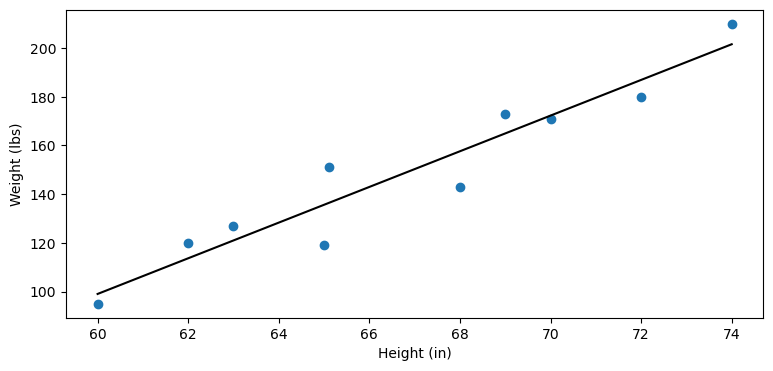

In [3]:
from lean.kf_book.gaussian_internal import plot_correlated_data

height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
plot_correlated_data(height, weight, 'Height (in)', 'Weight (lbs)', False)

在本书中，我们只考虑线性相关。我们假设变量之间的关系是线性的。也就是说，直线非常适合数据。我在上图中的数据中拟合了一条直线。非线性相关的概念是存在的，但我们不会使用它。

之间的协方差方程 $X$ 和 $Y$ 是

$$ COV(X, Y) = \sigma_{xy} = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

其中， $\mathbb E[X]$ 是 X 的期望值, 被定义为

$$\mathbb E[X] =  \begin{cases} \sum_{i=1}^n p_ix_i & \text{离散}\\ \int_{-\infty}^\infty f(x)\, x & \text{连续}\end{cases}$$

我们假设每个数据点的可能性相等，因此每个数据点的概率为$\frac{1}{N}$

$$\mathbb E[X] =  \frac{1}{N}\sum_{i=1}^n x_i$$

对于我们将考虑的离散情况。

将协方差方程与方差方程进行比较。如您所见，它们非常相似：

$$\begin{aligned}VAR(X) = \sigma_x^2 &= \mathbb E[(X - \mu)^2]\\
COV(X, Y) = \sigma_{xy} &= \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]\end{aligned}$$

特别是，如果您计算  $COV(X, X)$ 你得到的等式  $VAR(X)$ ，这支持了我的说法，即方差计算随机变量在自身之间如何变化。

我们使用协方差矩阵来表示多元正态分布的协方差，它看起来像这样：

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

对角线包含每个变量的方差，非对角线元素包含$i^{th}$ 和 $j^{th}$ 变量之间的协方差。所以 $\sigma_3^2$ 是第三个变量的方差，并且 $\sigma_{13}$ 是第一个变量和第三个变量之间的协方差。协方差为 0 表示没有相关性。如果 𝑥 的方差为 10，𝑦 的方差为4，并且 𝑥 和 𝑦 之间没有线性相关性，然后我们会写

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

如果𝑥 和 𝑦两者之间存在少量正相关，我们可能有

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

其中 1.2 是两者之间的协方差。我说相关性是“小”的，因为 1.2 的协方差相对于 10 的方差很小。

如果两者之间存在大量的负相关关系，我们可能有

$$\Sigma = \begin{bmatrix}10&-9.7\\-9.7&4\end{bmatrix}$$

协方差矩阵是对称的。毕竟，$x$ 和 $y$两者之间的协方差始终等于$y$ and $x$之间的协方差。也就是$\sigma_{xy}=\sigma_{yx}$，对于任何$x$ 和 $y$。

我担心我可能让你迷惑，所以让我们举个例子。在高斯章节中，我们有一班学生的身高为 H=[1.8， 2.0， 1.7， 1.9， 1.6] 米。我们计算：


$$\begin{aligned}
\mathit{VAR}(H) &= E[(H - \mu_H)^2] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i - \mu_H)^2 \\
&= \frac{1}{5}\left[(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2\right] \\
&= 0.02
\end{aligned}$$

很简单，对吧？如果我们对学生进行称重，我们可能会发现他们的权重为 W = [70.1， 91.2， 59.5， 93.2， 53.5]。我们可以使用协方差方程来创建协方差矩阵吗？当然，它将看起来像：

$$\Sigma = \begin{bmatrix}\sigma_H^2 & \sigma_{H,W} \\
\sigma_{W,H} & \sigma_{W}^2\end{bmatrix}$$

我们刚刚计算了高度的方差，它将位于矩阵的左上角。右下角包含权重的方差。使用相同的等式，我们得到：

$$\begin{aligned}
\mu_W &= \frac{1}{5}(70.1 + 91.2 + 59.5 + 93.2 + 53.5) = 73.5 \\
\sigma_W^2 &= \frac{1}{5}\left[(70.1-73.5)^2 + (91.2-73.5)^2 + (59.5-73.5)^2 + (93.2-73.5)^2 + (53.5-73.5)^2\right] \\
&= 261.8
\end{aligned}$$

现在是协方差。使用上面的公式，我们计算

$$\begin{aligned}
\sigma_{H,W} &= \mathbb E\big[(H-\mu_H)(W-\mu_W)\big] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i-\mu_H)(W_i-\mu_W) \\
&= \frac{1}{5}[(1.8-1.8)(70.1-73.5) + (2-1.8)(91.2-73.5) + (1.7-1.8)(59.5-73.5)\, +\\
&\, \, \, \,  \, (1.9-1.8)(93.2-73.5) + (1.6-1.8)(53.5-73.5)] \\
&= 2.18
\end{aligned}$$

这很乏味，但很容易。我们永远不会再这样做了，因为，当然，NumPy会为您计算它。

In [4]:
import numpy as np  
W = [70.1, 91.2, 59.5, 93.2, 53.5]
H = [1.8, 2.0, 1.7, 1.9, 1.6]
np.cov(H, W)

array([[  0.025,   2.727],
       [  2.727, 327.235]])

这与我们的计算不符！出了什么问题？没有什么。NumPy 对小样本量应用校正;它使用 $\frac{1}{N-1}$ 作为规范化项，而不是 $\frac{1}{N}$。

这有点超出本书的范围。简而言之，假设实际班级规模是 200 名学生，我们抽取了 5 名学生的样本来执行此计算，因为我们负担不起测量和称重所有 200 名学生的费用。几乎可以肯定，我们的估计器中会有一些误差，因为样本不太可能完美地表示该类。当我们的样本量接近 200 时，误差将接近 0。我们说后者没有偏见，我们有一个无偏见的估计器(无偏估计)。相反，当我们取一个小样本时，存在偏差（误差为非零），并且我们有一个有偏差的估计器(有偏估计)。

如果误差为零，则除以 $𝑁$ 是有意义的。我不会证明为什么，但对于我们有偏见的估计器，我们使用 $\frac{1}{N-1}$ 以校正小样本量。NumPy 默认这样做，因为在实践中，我们几乎总是使用来自较大集合的数据样本。如果你想要我们上面计算的无偏估计器，请使用bias=1去调用“np.cov”。

In [5]:
# numpy默认是有偏估计
# 当bias=1时，表示计算无偏估计
np.cov(H, W, bias=1)

array([[  0.02 ,   2.182],
       [  2.182, 261.788]])

这与我们的计算一致。我们不会在本书中再次使用bias=1，因为我们使用的是随机变量，这些变量是从我们正在跟踪的对象的无限位置集中采样的。在这里，我们正在计算整个总体的方差和协方差，因此bias=1是正确的。

这个矩阵告诉我们什么？它告诉我们高度方差为 0.02 $m^2$ 权重方差为 261.788 $kg^2$。此外，它告诉我们体重和身高呈正相关 - 随着身高的增加，重量也会增加。

让我们创建完全相关的数据。我的意思是数据完全适合一行 - 与行没有差异。

In [6]:
X = np.linspace(1, 10, 100)
Y = np.linspace(1, 10, 100)
np.cov(X, Y)

array([[6.956, 6.956],
       [6.956, 6.956]])

我们可以从协方差矩阵中看到，协方差等于 x 和 y 中的方差。

现在，让我们向其中一个变量添加一些噪声，以便它们不再完全相关。我会做的 𝑌 负数以创建负相关。

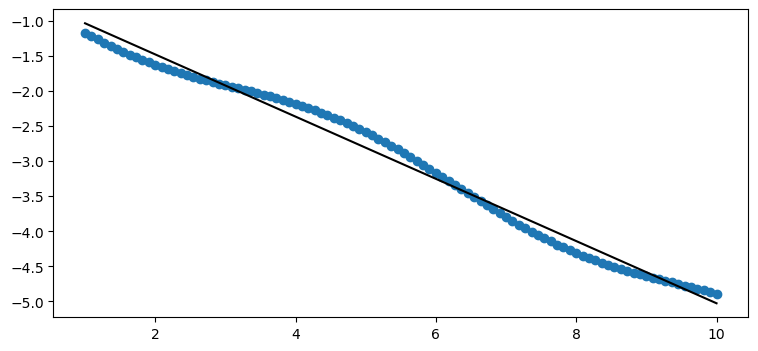

[[ 6.956 -3.084]
 [-3.084  1.387]]


In [7]:
X = np.linspace(1, 10, 100)
Y = -(np.linspace(1, 5, 100) + np.sin(X)*.2)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

据不再形成直线。协方差为 $\sigma_{xy}=-3.08$。协方差与$\sigma_x^2$ 和 $\sigma_y^2$大小相比，不趋于零，因此我们知道它们仍然存在高度的相关性。
我们可以通过查看图表来验证这一点。数据几乎形成一条直线。

现在我将向直线添加随机噪声。


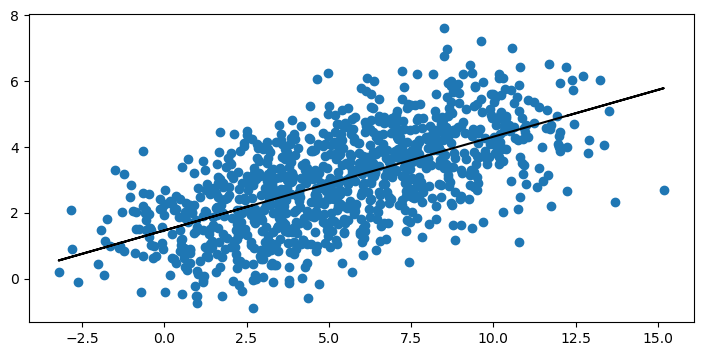

[[10.861  3.092]
 [ 3.092  2.284]]


In [8]:
from numpy.random import randn
X = np.linspace(1, 10, 1000) + randn(1000)*2
Y = np.linspace(1, 5, 1000) + randn(1000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

我们看到协方差相对于方差较小，反映了 𝑋 和 𝑌之间较低的相关性。我们仍然可以通过这些数据拟合一条直线，但数据的变化要大得多。

最后，这里是完全随机数据之间的协方差。

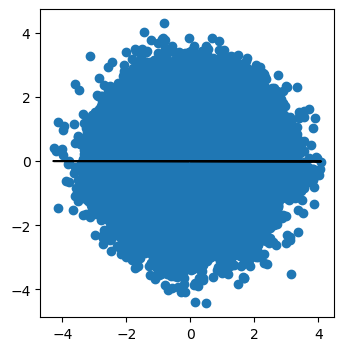

[[ 0.992 -0.001]
 [-0.001  0.997]]


In [9]:
X = randn(100000)
Y = randn(100000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

这里的协方差非常接近于零。正如您在图中所看到的，没有明确的方法来绘制一条线来拟合数据。垂直线与我显示的水平线一样没有说服力。

### 多元正态分布方程

回想一下高斯一章中的正态分布方程：

$$ 
f(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \Big [{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 \Big ]
$$

这是多元正态分布 𝑛 尺寸。

$$
f(\mathbf{x},\, \mu,\,\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\, \exp  \Big [{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) \Big ]}
$$

多元版本只是用矩阵替换单变量方程的标量。如果你相当精通线性代数，这个方程应该看起来很容易管理。如果没有，请不要担心，FilterPy 和 SciPy 都提供了为您计算它的函数。让我们暂时忽略计算并绘制它以查看它的外观。

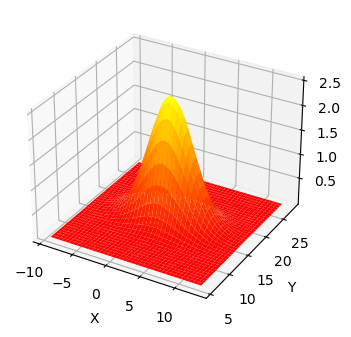

In [10]:
import lean.kf_book.mkf_internal as mkf_internal

mean = [2., 17.]
cov = [[10., 0.], 
       [0., 4.]]

mkf_internal.plot_3d_covariance(mean, cov)

这是一个多元高斯图，均值为 $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ 和协方差 $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$。三维形状在 z 轴上显示任意值的概率密度 (𝑋,𝑌)。我已经将 x 和 y 的方差投影到图表的墙壁上 - 您可以看到它们呈现高斯钟形曲线形状。曲线 𝑋 比 的曲线宽 𝑌 ，这可以通过方差解释，它们的方差是 $\sigma_x^2=10$ and $\sigma_y^2=4$。3D 表面的最高点位于 𝑋 和 𝑌的均值处。

所有多元高斯都有这种形状。如果我们将其视为狗位置的高斯，则 ($X, Y$) 是狗处于该位置的概率密度。严格来说，这是联合概率密度函数，我将很快定义。因此，狗靠近（2，17）的概率最高，靠近（5，14）的概率适中，靠近（10，10）的概率非常低。与单变量情况一样，这是一个概率密度，而不是概率。连续分布具有无限范围，因此正好位于 （2， 17） 或任何其他点的概率为 0%。我们可以通过用积分计算表面下的体积来计算在给定范围内的概率。

FilterPy在filterpy.stats.模块中使用multivariate_gaussian()函数实现了方程。SciPy 中stats模块使用multivariate_normal()实现了多元正态分布方程。它实现了一个“冻结”形式，您可以在其中设置一次均值和协方差，然后计算任意数量、任何 x 值的概率密度。我命名了我的函数multivariate_gaussian()，以确保它永远不会与 SciPy 版本混淆。

> 该scipy.stats模块的<a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">教程</a>[1] 解释了“冻结”分布和其他非常有用的功能。

In [11]:
from filterpy.stats import gaussian, multivariate_gaussian

我将演示如何使用它，然后继续讨论更有趣的事情。

首先，让我们找到我们的狗在 (2.5, 7.3) 的概率密度，如果我们相信它在 (2, 7)，x的方差为8、y的方差为3。
 .

开始设置 𝑥为(2.5, 7.3)。您可以使用元组、列表或 NumPy 数组。

In [12]:
x = [2.5, 7.3]

接下来，我们设定信念的平均值：

In [13]:
mu = [2.0, 7.0]

最后，我们必须定义协方差矩阵。在问题陈述中，我们没有提到𝑥 和 𝑦两者之间的任何相关性，我们将假设没有。这是有道理的，狗可以选择独立徘徊在 𝑥 方向或 𝑦方向不相互影响。我将使用变量名P.卡尔曼滤波器使用名称 𝐏表示协方差矩阵，我们需要熟悉约定。

In [14]:
P = [[8., 0.], 
     [0., 3.]]

现在调用函数

In [15]:
%precision 4

# 狗在x位置的概率密度
multivariate_gaussian(x, mu, P)

0.0315

我们可以从scipy.stats模块中获得相同的结果

In [16]:
import scipy
from scipy.stats import multivariate_normal
print(f'{multivariate_normal(mu, P).pdf(x):.4f}')

0.0315


是时候定义一些术语了。**联合概率**，表示为 𝑃(x，y)，它是$x$ 和 $y$两者同时发生的概率。例如，如果您掷两个骰子 $P(2,5)$，它表示第一个骰子掷 2 和第二个骰子掷 5 的概率。假设骰子是六面且公平的，概率 $P(2,5) = \frac{1}{6}\times \frac{1}{6}=\frac{1}{36}$。上面的 3D 图表显示了联合概率密度函数。

**边缘概率**是事件发生而不考虑任何其他事件的概率。在上面的图表中，向左绘制的高斯曲线是 𝑌的边缘分布。在不考虑 𝑋的情况下，这是狗处于 𝑌轴上任何位置的概率。早些时候，我写过“我已经将 x 和 y 的方差投影到图表的墙上”。这些是 𝑥 和 𝑦边际概率。高斯的另一个计算好处是多元高斯的边际是另一个高斯！

让我们以稍微不同的方式看待这个问题。而不是绘制显示概率分布的表面，我将生成 1000 个点，分布为 $[\begin{smallmatrix}8&0\\0&3\end{smallmatrix}]$。

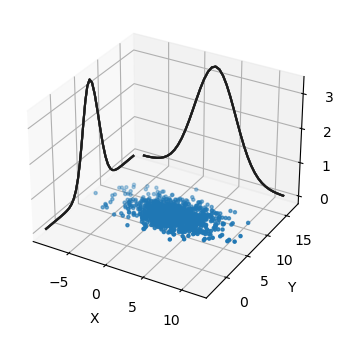

In [17]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

我们可以将采样点视为给定这些特定均值和协方差的狗的可能位置。侧面的等值线显示 𝑋 和 𝑌的边际概率。 我们可以看到，他更有可能在有很多点的（2，7）处，而不是在（-5，5）点很少的地方。

尽管这些情节很漂亮，但很难从中获得有用的信息。例如，不容易判断是否 𝑋 和 𝑌 两者具有相同的方差，以及它们的相关性。在本书的大部分内容中，我将高斯图显示为等高线图。

等值线图显示多元高斯对特定标准差取的值范围。这就像从 3D 绘图中取出水平切片一样。

这些图显示了 3 个标准差的切片形状。

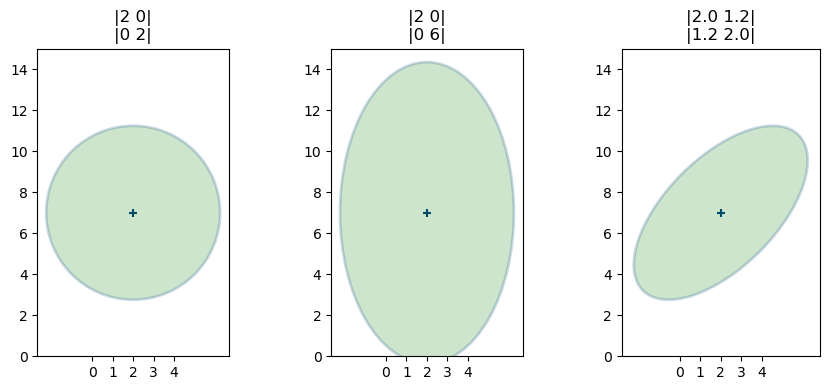

In [18]:
mkf_internal.plot_3_covariances()

对于那些在线或在计算机上的Juptyer Notebook中查看此内容的人，这里有一个在保持方差常数的同时改变协方差的动画。

<img src='lean/animations/multivariate_ellipse.gif'>

(来源: http://git.io/vqxLS)

这些图看起来像圆形和椭圆。事实上，事实证明，任何通过多元高斯的切片都是椭圆。因此，在统计学中，我们不称这些为“等值线图”，而是称为误差椭圆或置信椭圆，这些术语是可以互换的。

此代码使用来自 filterpy.stats模块的 plot_covariance_ellipse()函数。默认情况下，该函数显示一个标准偏差，但您可以使用variance 或者 std参数来控制显示的内容。例如，`variance=3**2` 或者 `std=3`将显示3个标准差。而且`variance=[1,4,9]` 或者 `std=[1,2,3]`将显示第 1、第 2 和第 3 个标准差。

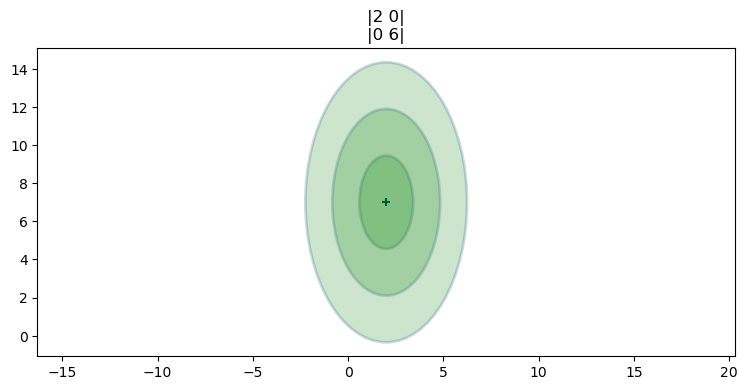

In [19]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

P = [[2, 0], [0, 6]]
plot_covariance_ellipse((2, 7), P, fc='g', alpha=0.2, 
                        std=[1, 2, 3],
                        title='|2 0|\n|0 6|')
plt.gca().grid(b=False);

纯色可能向您表明标准差之间的概率分布是恒定的。这不是真的，正如你从高斯的 3D 图中可以看出的那样。下面是协方差 ($\begin{smallmatrix}2&1.2\\1.2&1.3\end{smallmatrix})$。深灰色对应于较高的概率密度。

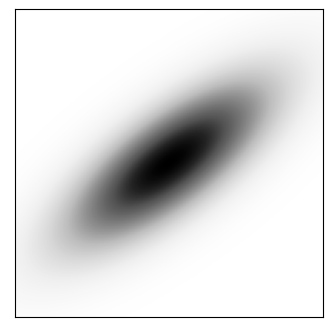

In [20]:
from lean.kf_book.nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 1.2], [1.2, 1.3]])

思考这些情节的物理解释可以澄清它们的含义。第一个图的均值和协方差为

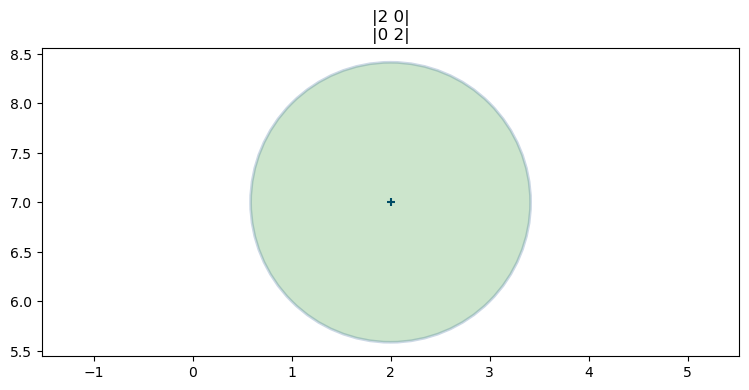

In [21]:
x = [2, 7]
P = [[2, 0], [0, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                       title='|2 0|\n|0 2|')
plt.gca().grid(b=False)

贝叶斯思考这个问题的一种方式是，椭圆向我们展示了我们信念中的错误量。一个小圆圈表示我们有一个非常小的错误，一个非常大的圆圈表示我们的信念有很多错误。椭圆的形状向我们展示了 𝑋和 𝑌误差的几何关系.这里我们有一个圆圈，所以错误在 𝑋和 𝑌 方向是相同可能性的。

第二个图的均值和协方差为



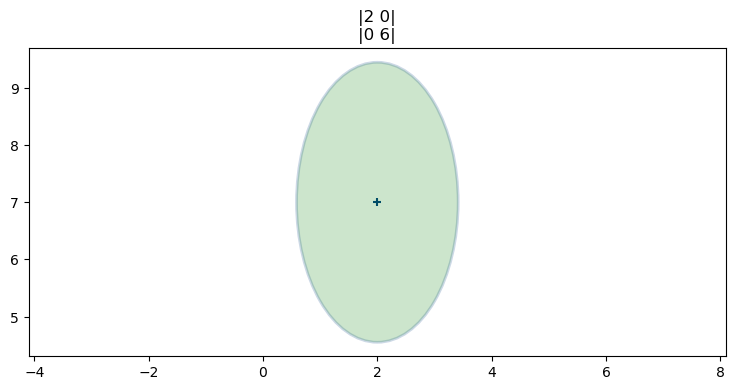

In [22]:
x = [2, 7]
P = [[2, 0], [0, 6]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 0|\n|0 6|')
plt.gca().grid(b=False)

这一次我们使用不同的方差$X$ ($\sigma_x^2=2$) vs $Y$ ($\sigma^2_y=6$)。结果是一个又高又窄的椭圆。我们可以看到，𝑌 比 𝑋具有更多的不确定性。在这两种情况下，我们相信狗在（2，7），但是这种不确定性是不同的。

第三个图显示均值和协方差

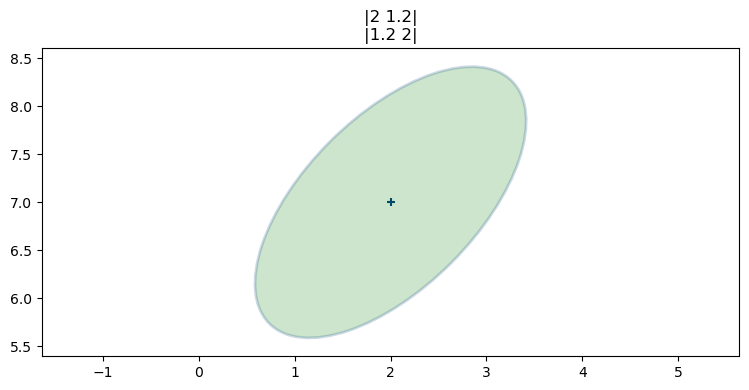

In [23]:
x = [2, 7]
P = [[2, 1.2], [1.2, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 1.2|\n|1.2 2|')

这是在协方差的非对角线元素中具有值的第一个等值线，这是第一个具有倾斜椭圆的等值线图。这不是巧合。这两个事实告诉我们同样的事情。倾斜的椭圆告诉我们 𝑥 和 𝑦 值在某种程度上是相关的。协方差矩阵中的非对角元素不为零，表示存在相关性。

回想一下身高与体重的图。它形成了一个倾斜的点组。我们可以使用 NumPy 的函数通过将两个或多个变量放入 2D 数组来计算它们的协方差。让我们这样做，然后绘制2σ数据顶部的协方差椭圆。我们将需要使用bias=1，因为数据代表整个人口，而不是样本。

In [24]:
cov_hw = np.cov(np.vstack((height, weight)), bias=1)
cov_hw

array([[  18.5249,  135.701 ],
       [ 135.701 , 1092.29  ]])

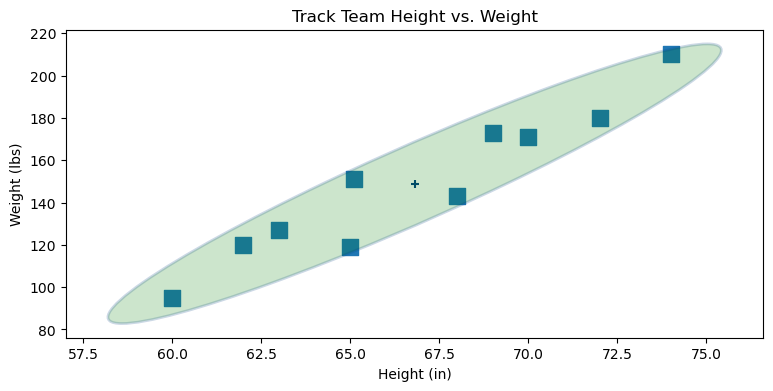

In [25]:
plt.scatter(height, weight, s=120, marker='s')
plt.title('Track Team Height vs. Weight')
plt.xlabel('Height (in)'); plt.ylabel('Weight (lbs)')
plot_covariance_ellipse((np.mean(height), np.mean(weight)), cov_hw, fc='g', 
                        alpha=0.2, axis_equal=False, std=2)

这应该可以帮助您对协方差的含义和用法形成强烈的直觉。协方差椭圆显示数据如何彼此“分散”。像这样的窄椭圆告诉您数据非常相关。对于任何给定的高度，重量范围很窄。椭圆向右倾斜，告诉我们存在正相关 - 随着 x 的增加，y 也会增加。如果椭圆向左倾斜，则相关性为负 - 随着 x 的增加，y 减小。我们可以在下图中看到这一点：

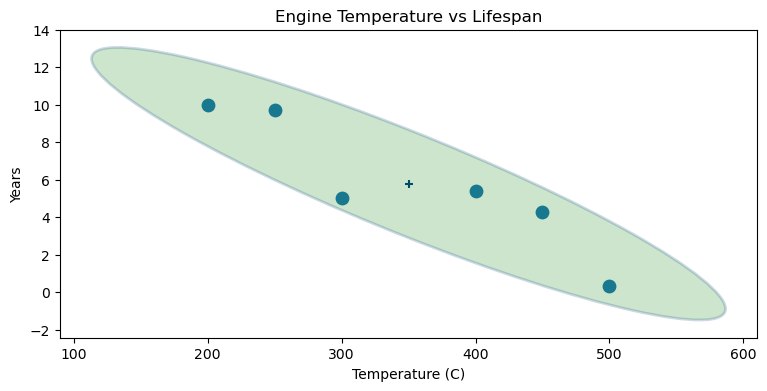

In [26]:
max_temp = [200, 250, 300, 400, 450, 500]
lifespan = [10, 9.7, 5, 5.4, 4.3, 0.3]

plt.scatter(max_temp, lifespan, s=80)
cov = np.cov(np.vstack((max_temp, lifespan)))
plot_covariance_ellipse((np.mean(max_temp), np.mean(lifespan)), cov, fc='g', 
            alpha=0.2, axis_equal=False, std=2)
plt.title('Engine Temperature vs Lifespan')
plt.xlabel('Temperature (C)'); plt.ylabel('Years');

方差和协方差之间的关系很难通过检查来解开，所以这里有一个交互式图。（如果您正在以静态形式阅读本文，请在此处在线运行此说明：https://git.io/vza7b)

In [27]:
from ipywidgets import interact
from lean.kf_book.book_plots import figsize, FloatSlider

fig = None
def plot_covariance(var_x, var_y, cov_xy):
    global fig
    if fig: plt.close(fig)
    fig = plt.figure(figsize=(4,4))
    P1 = [[var_x, cov_xy], [cov_xy, var_y]]

    plot_covariance_ellipse((10, 10), P1, axis_equal=False,
                            show_semiaxis=True)

    plt.xlim(4, 16)
    plt.gca().set_aspect('equal')
    plt.ylim(4, 16)

    
with figsize(y=6):
    interact (plot_covariance,           
          var_x=FloatSlider(5, min=0, max=20), 
          var_y=FloatSlider(5, min=0, max=20), 
          cov_xy=FloatSlider(1.5, min=0, max=50, step=.2));

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='var_x', max=20.0), FloatSli…

### 皮尔逊相关系数

我们不会在本书中使用这个系数，但你可以在其他地方看到它。如果不感兴趣，您可以安全地跳过此部分。

两个变量之间的相关性可以用皮尔逊相关系数给出一个数值。它被定义为

$$\rho_{xy} = \frac{COV(X, Y)}{\sigma_x \sigma_y}$$

此值的范围可以从 -1 到 1。如果协方差为 0 则 ρ=0 .如果大于 0 的值表示关系为正相关，负值表示存在负相关。接近 -1 或 1 的值表示非常强的相关性，接近 0 的值表示非常弱的相关性。

相关性和协方差密切相关。协方差具有单位，相关性是无单位比率。例如，对于我们的狗$\sigma_{xy}$单位为米的平方。

我们可以使用`scipy.stats.pearsonr` 函数来计算皮尔逊系数。它返回皮尔逊系数和 2 tailed p-value的元组。本书中未使用后者。在这里我们计算学生运动员的身高与体重的$\rho$。

In [28]:
from scipy.stats import pearsonr
pearsonr(height, weight)[0]

0.9539731096080194

在这里，我们计算发动机温度与使用寿命之间的相关性。

In [29]:
pearsonr(max_temp, lifespan)[0]

-0.9178223453527254

### 使用相关性改进估计值

假设我们相信我们的狗处于位置（5，10），并具有一些给定的协方差。如果 x 和 y 中的标准差各为 2 米，但它们密切相关，则协方差等值线将如下所示。

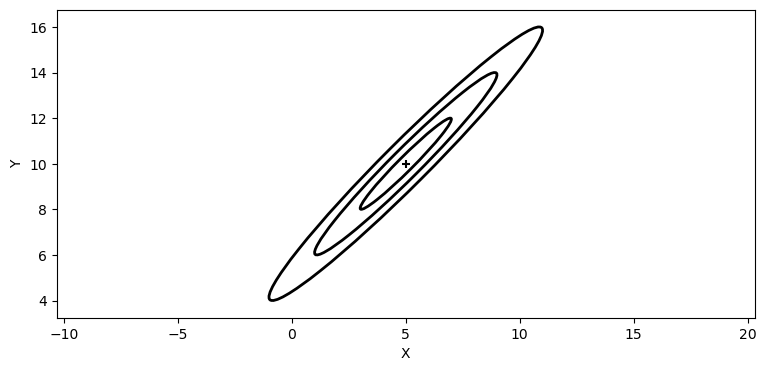

In [30]:
P = [[4, 3.9], [3.9, 4]]

plot_covariance_ellipse((5, 10), P, ec='k', std=[1, 2, 3])
plt.xlabel('X')
plt.ylabel('Y');

现在假设我要告诉你，我们知道 x=7.5.我们可以推断出什么值 𝑦 ?该位置极有可能位于 3 σ 协方差椭圆。我们可以根据协方差矩阵推断 y 中的位置，因为 x 和 y 之间存在相关性。我已经将 y 的值的可能范围说明为蓝色填充圆圈

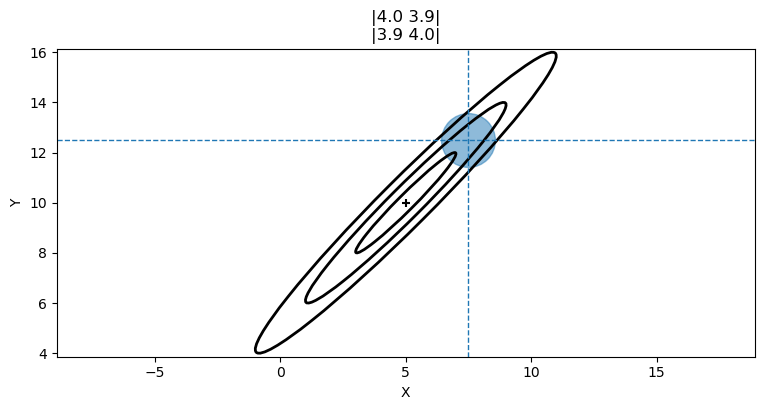

In [31]:
mkf_internal.plot_correlation_covariance()

这个圆在数学上不正确，但它传达了这个想法。我们将在下一节中解决数学问题。现在认识到我们可以预测 𝑦 可能在 12 点附近。值为 y=−10 是极不可能的。

关于相关性和独立性的一句话。如果变量是独立的，它们可以单独变化。如果你走在空旷的田野里，你可以在 𝑥 方向（东西）， 𝑦 方向（南北），或其任意组合。自变量也总是不相关的。除特殊情况外，反之则不成立。变量可以不相关，但相互依赖。例如，考虑$y=x^2$.相关性是一种线性测量，因此 𝑥 和 𝑦 不相关。然而 𝑦 取决于 𝑥。

### 多维高斯相乘

在上一章中，我们通过高斯相乘将不确定性估计与不确定性测量相结合。结果是另一个较小方差的高斯。如果两条不确定的信息相互纠正，我们应该在结论中更加确定。图表如下所示：

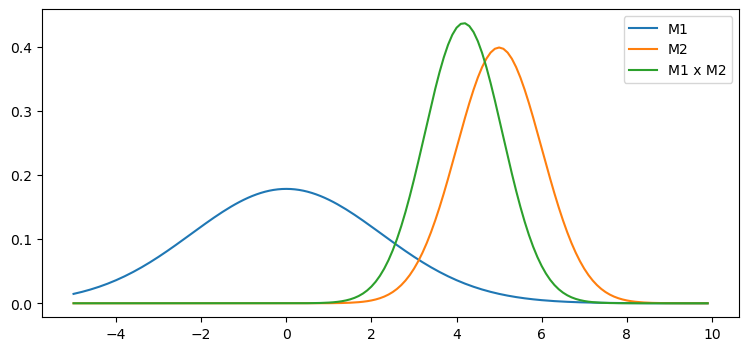

In [32]:
mkf_internal.plot_gaussian_multiply()

测量值 1 和测量值 2 的组合产生更高的确定性，因此新的高斯更高更窄 - 方差变小。对于多元高斯，在多个维度上也会发生同样的情况。以下是乘以多元高斯的方程。大写西格玛（$\Sigma$） 表示这些是矩阵，而不是标量。具体来说，它们是协方差矩阵：

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

它们是通过将先验和估计的多元高斯插入贝叶斯定理生成的。我给了你高斯一章中单变量情况的代数。

您无需记住这些方程，因为它们是由卡尔曼滤波方程计算的，很快就会介绍。此计算可以在 FilterPy 中使用该multivariate_multiply()方法，您还可以从 filterpy.stats 导入。

为了给你一些直觉，回想一下乘以单变量高斯的方程：

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

这看起来类似于多元方程的方程。如果您认识到矩阵逆（由 -1 次方表示）就像倒数一样，这将更加明显，因为 $AA^{-1} =I$ .我将反转重写为除法 - 这不是数学上正确的做法，因为矩阵的除法没有定义，但它确实有助于我们比较方程。

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

在这种形式中，单变量方程和多元方程之间的关系是明确的。

现在让我们用一个具体的例子来探讨多元高斯。假设我们正在跟踪一架带有两个雷达系统的飞机。我将忽略高度，以便我可以使用二维图。雷达提供目标的范围和方位。我们一开始不确定飞机的位置，所以协方差，即我们对位置的不确定性，可能看起来像这样。用贝叶斯统计的语言来说，这是我们的先验。

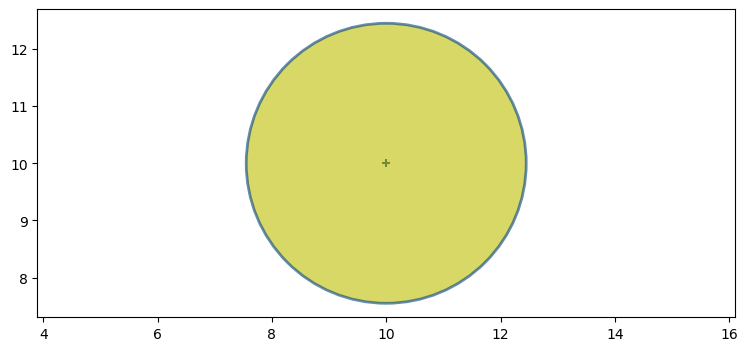

In [33]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)

现在假设飞机左下角有一个雷达。进一步假设雷达的方位测量是准确的，但距离测量是不准确的。测量误差的协方差可能如下所示（在黄色先验值之上以绿色绘制）：

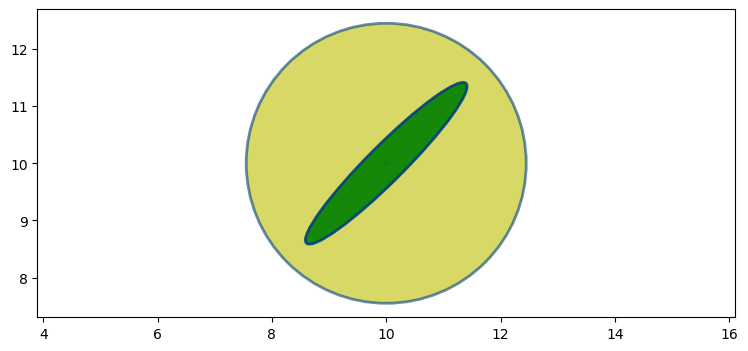

In [34]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

回想一下，贝叶斯统计称之为证据。椭圆点指向雷达。它很长，因为距离测量不准确，并且飞机可能在测量范围的相当远的距离内。它非常窄，因为方位估计非常准确，因此飞机必须非常接近方位估计。

我们希望找到后验 - 将证据纳入先验结果的均值和协方差。就像在每一章中一样，我们通过将它们相乘来组合证据。

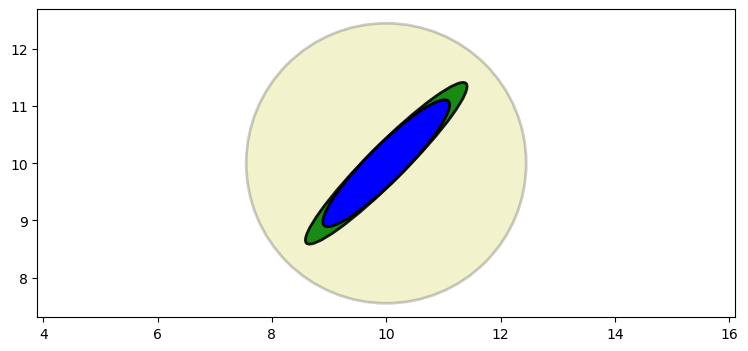

In [35]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

我用非常透明的黄色绘制了原始估计值（先前），将雷达读数绘制为绿色（证据），将最终估计值（后验）绘制为蓝色。

后部保留了与雷达测量相同的形状和位置，但较小。我们已经在一维高斯身上看到了这一点。将两个高斯相乘会使方差更小，因为我们合并了更多信息，因此我们的不确定性较小。需要认识到的另一点是协方差形状反映了飞机和雷达系统的物理布局。这一点的重要性将在下一步中变得清晰。

现在，假设我们从第二个雷达获得测量结果，这个雷达在右下角。最后一步的后验成为我们的新先验，我用黄色绘制。新测量值以绿色绘制。


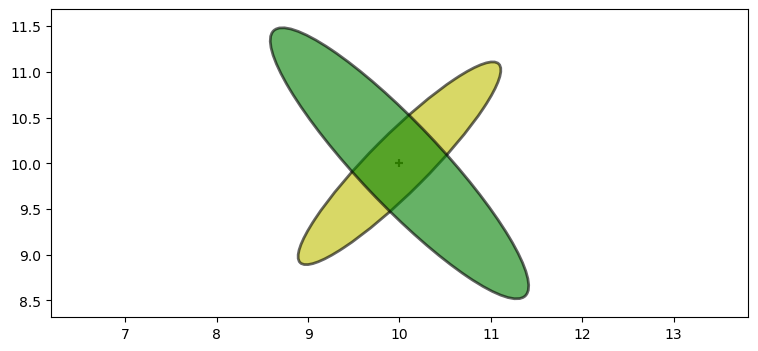

In [36]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

我们通过乘以高斯来合并此信息：

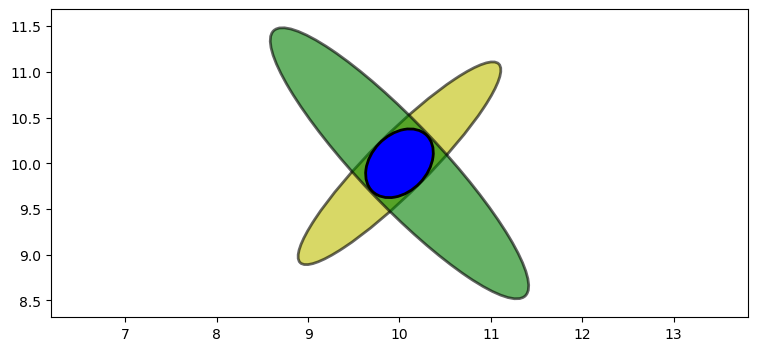

In [37]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

飞机唯一可能的位置是两个椭圆相交的地方。由先验和测量相乘形成的交集是一个新的高斯。形状反映了问题的几何形状。这使我们能够在飞机上进行三角测量，从而得出非常准确的估计。我们没有显式编写任何代码来执行三角测量;这是将每个测量的高斯相乘的自然结果。

回想一下g-h Filter一章，我们在秤上显示了两个称量误差线。估计值必须落在误差线重叠的区域内的某个地方。这里的估计必须在 161 到 163 磅之间。

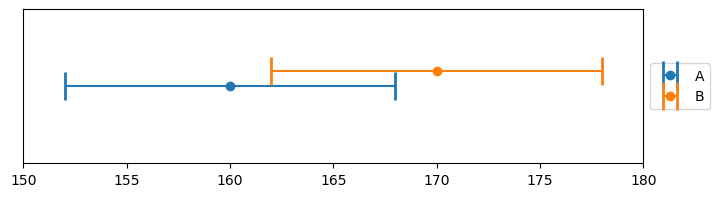

In [38]:
import lean.kf_book.book_plots as book_plots
book_plots.plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

让我们考虑一个不同的布局。假设第一个雷达直接在飞机的左侧。我可以用

$$\Sigma = \begin{bmatrix}2&0\\0&0.2\end{bmatrix}$$

在这里，我们看到将先验乘以测量的结果。

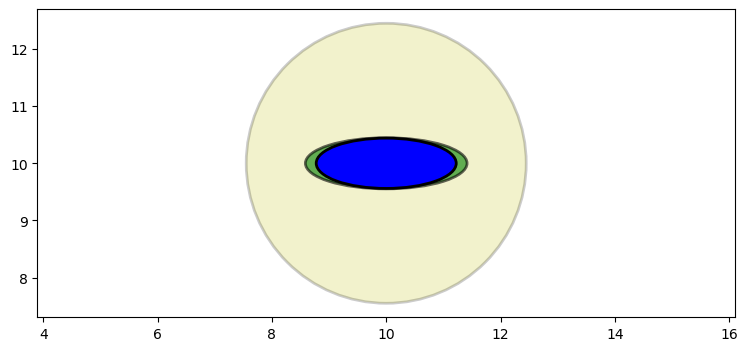

In [39]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

现在我们可以合并来自第二个雷达系统的测量结果，我们将将其保留在与以前相同的位置。

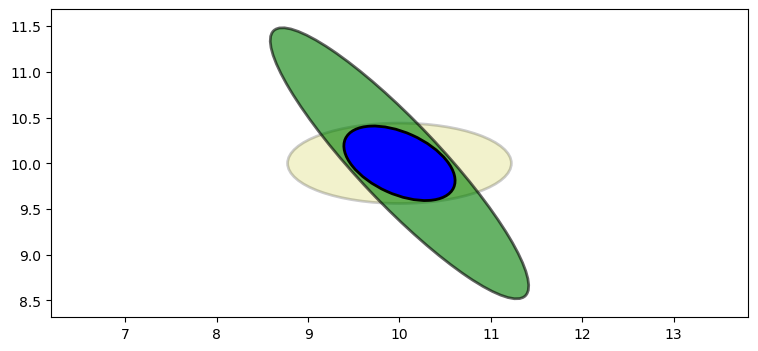

In [40]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

我们的估计不如前面的例子准确。两个雷达站相对于飞机的位置不再彼此正交，因此三角测量不是最佳的。

最后一个例子，想象一下从同一雷达进行两次测量，相隔很短的时间。协方差椭圆几乎重叠，在我们的新估计中留下一个非常大的误差:

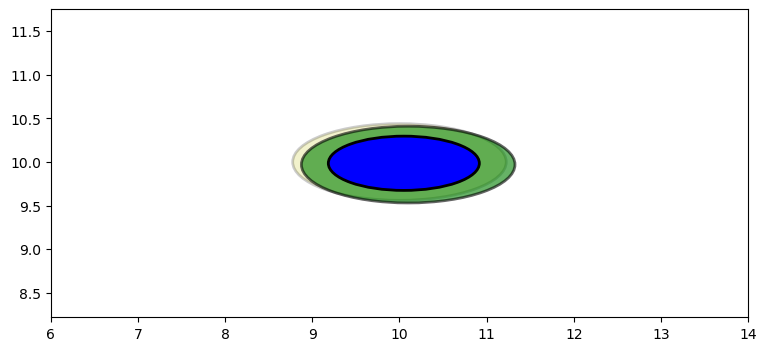

In [41]:
P5 = multivariate_multiply((10,10), P2, (10.1, 9.97), P2)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10.1, 9.97), P2, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse(P5[0], P5[1], ec='k', fc='b')
plt.xlim(6, 14);

### 隐藏变量

您已经可以看到为什么多变量卡尔曼滤波器比单变量卡尔曼滤波器表现更好。变量之间的相关性可以显著改善我们的估计。我们可以更进一步。本节包含本章的关键见解，因此请仔细阅读。

假设我们正在跟踪一架飞机，我们得到以下数据 𝑥和 𝑦 时间坐标 𝑡 =1、2 和 3 秒。你的直觉告诉你会值 在时间 𝑡 =4秒

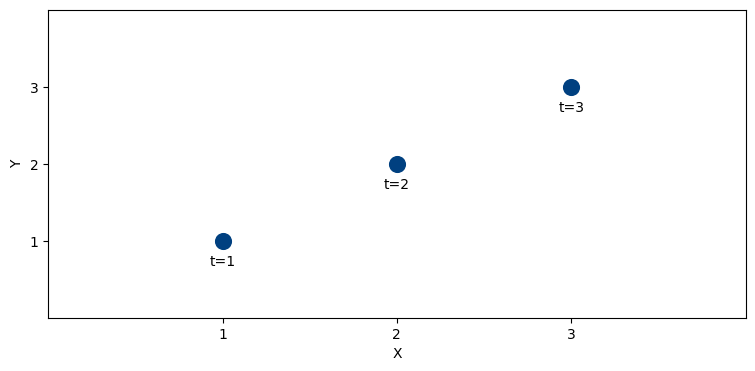

In [42]:
mkf_internal.show_position_chart()

飞机似乎在直线飞行，我们知道飞机不能打开一角钱。最合理的猜测是 𝑡 =4 飞机在 （4，4）。我将用绿色箭头来描述它。

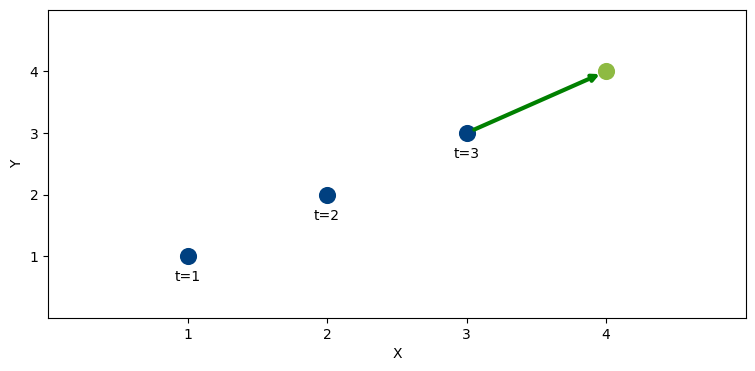

In [43]:
mkf_internal.show_position_prediction_chart()